# Assignment Number 1
Adam Zelzer, ID 328489166
### Table of Contents

* [Question 1](#Question1)
* [Question 2](#Question2)
* [Question 3](#Question3)

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Question 1 <a class="anchor" id="Question1"></a>
First, we'll load the dataset:

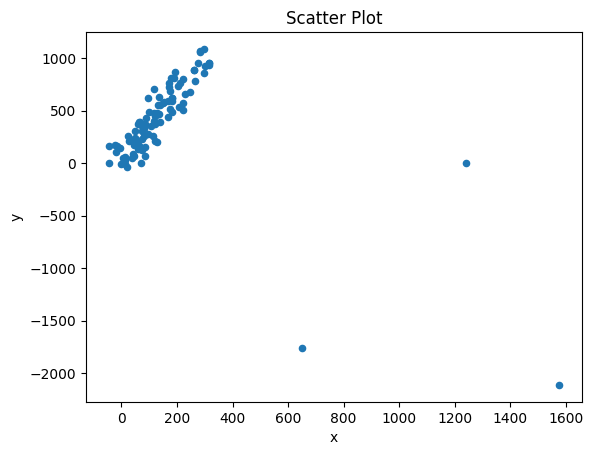

In [172]:
data1 = pd.read_parquet("data1.parquet")
_ = data1.plot(kind="scatter", x="x", y="y", title="Scatter Plot")

We can immediately spot outliars! we'll get rid of them.

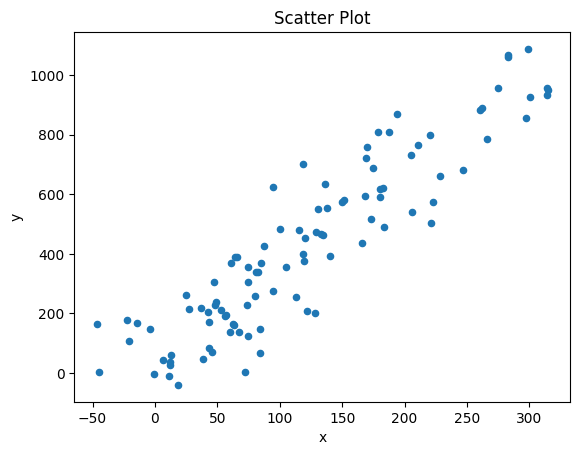

In [173]:
data1.drop(index=data1[data1["x"]>500].index, inplace=True)
_ = data1.plot(kind="scatter", x="x", y="y", title="Scatter Plot")

This looks much better. Now, we'll use a model called **Deming Regression**, which takes into account variance in both $X$ and $Y$.

Our assumptions:

* $X_i=x^*_i+\delta_i\sim\mathcal{N}\left(x^*_i,\sigma_x^2\right), Y_i=y^*_i+\varepsilon_i\sim\mathcal{N}\left(y^*_i,\sigma_y^2\right)$, and they are independent.
* $\forall i: y^*_i=\beta_0+\beta_1x^*_i$
* The variance ratio $\lambda=\frac{\sigma_y^2}{\sigma_x^2}$ is known.
* $(x_i,y_i), 1 \leq i\leq n$ are realizations of $(X_i,Y_i)$.


Under these assumptions, our loss is the log-likelihood, which becomes (after removing constants): 

$$\ell(\beta,x^*)=\sum_{i=1}^n\left(\lambda(x_i-x_i^*)^2+(y_i-\beta_0-\beta_1x_i^*)^2\right)$$

Differentiating and equating to 0, the solutions are:

$$\beta_1=\frac{s_{yy}-\lambda s_{xx}+\sqrt{(s_{yy}-\lambda s_{xx})^2+4\lambda s_{xy}^2}}{2s_{xy}}, \beta_0=\bar{y}-\beta_1\bar{x}$$

where $\bar{x},\bar{y}$ are the sample means, and $s_{xx},s_{xy},s_{yy}$ are the sample variances and covariance. Now, we'll implement this algortihm.

In [174]:
def deming_reg(x,y,lamb):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x2_mean = np.mean(x**2)
    y2_mean = np.mean(y**2)
    xy_mean = np.mean(x*y)
    s_xx = x2_mean - x_mean**2
    s_yy = y2_mean - y_mean**2
    s_xy = xy_mean - x_mean*y_mean
    temp = s_yy - lamb*s_xx

    beta_1 = (temp + np.sqrt(temp**2+4*lamb*s_xy**2))/(2*s_xy)
    beta_0 = y_mean - beta_1*x_mean

    return (beta_0, beta_1)

In [175]:
from sklearn.linear_model import LinearRegression

x = data1["x"].values
y = data1["y"].values

#Linear regression
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(x.reshape(-1,1), y)
alpha_0, alpha_1 = lin_reg.intercept_, lin_reg.coef_ [0]
print(alpha_0, alpha_1)

#Deming regression
beta_0, beta_1 = deming_reg(x,y,2)
print(beta_0, beta_1)

70.02365496350131 2.973585048126178
11.02781183314272 3.4627270820540272


Finally, we'll plot both of our results.

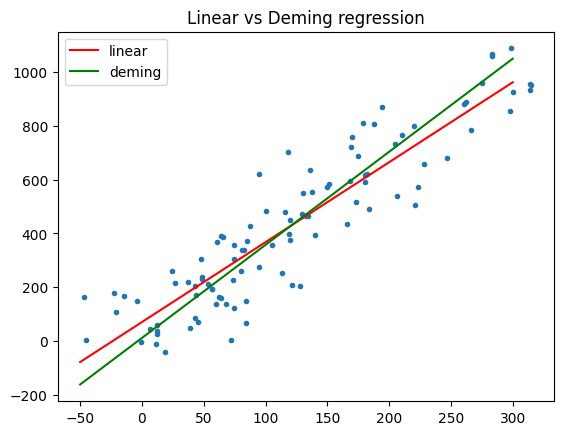

In [176]:
x_new = np.linspace(-50, 300, 351)
y_lin = lin_reg.predict(x_new.reshape(-1,1))
y_deming = beta_0 + beta_1 * x_new

plt.plot(x,y,".")
plt.plot(x_new, y_lin, "r-", label='linear')
plt.plot(x_new, y_deming, "g-", label='deming')
plt.title("Linear vs Deming regression")
plt.legend()
plt.show()

## Question 2 <a class="anchor" id="Question2"></a>
First, we'll load the dataset:

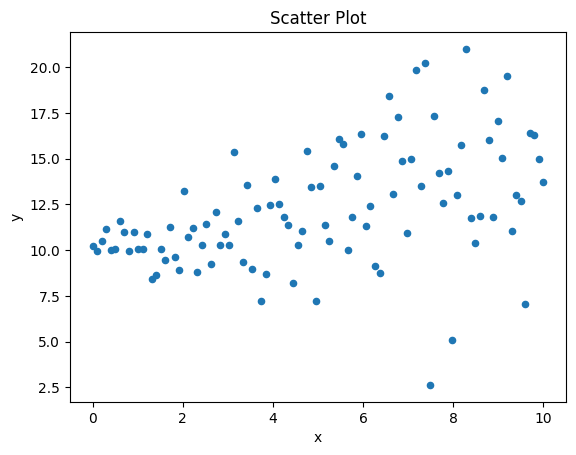

In [177]:
data2 = pd.read_parquet("data2.parquet")
_ = data2.plot(kind="scatter", x="x", y="y", title="Scatter Plot")

This data doesn't seem as if it quite suits a straight line - the variance seems to increase. Lets check the residuals:

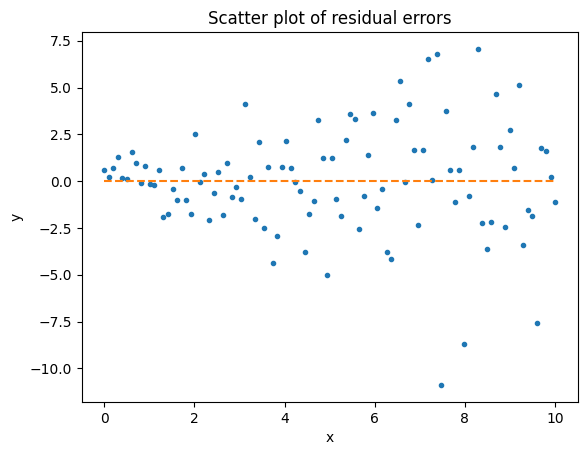

In [178]:
x = data2["x"].values
y = data2["y"].values

#Linear regression
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(x.reshape(-1,1), y)

#plot residuals
y_lin = lin_reg.predict(x.reshape(-1,1))
plt.plot(x,y-y_lin,".")
plt.plot(x, np.zeros((len(x))), "--", label='linear')
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Scatter plot of residual errors")

Indeed, we can spot a phenomenon called **heteroscedasticity**, which refers to situations where the variance of the residuals is unequal over the range of predictions. This violates one of the assumptions of linear regression - the "noise" of each sample must have the same variance.
In this case, we can use a different technique, called **Quantile Regression**, which, as the name suggests, tries to predict the quantiles of $P(Y|X)$.

### Quantile regression - theory

Let $X$ be a RV with cdf $F_X(x)$, and $\tau\in(0,1)$ be some number. the $\tau$'th quanitle of $X$ is given by:
$$Q_X(\tau)=\inf\left\{x|F_X(x)\ge\tau\right\}$$
It can be shown that:
$$(*)\ Q_X(\tau)=\arg\min_t\mathbb{E}[\rho_{\tau}(X-t)]$$
Where $\rho_{\tau}(z)=z\cdot\left(\tau-\mathbb{I}_{(-\infty,0)}(z)\right)$ is our loss function.
Quantile regression assumes the conditional quantiles are linear in $x$, meaning:
$$Q_{Y|X=x}(\tau)=\beta^T\cdot x$$
It returns the parameter vector:
$$\hat{\beta}=\arg\min_\beta\frac{1}{n}\sum_{i=1}^n\rho_{\tau}\left(y_i-\beta^T\cdot x_i\right)$$
Which is the empirical form of $(*)$.

**Note:** When $\tau=0.5$, we get $\rho_{0.5}(z)=\frac{1}{2}|z|$, and:
$$\hat{\beta}=\arg\min_\beta\frac{1}{2n}\sum_{i=1}^n|y_i-\beta^T\cdot x_i|$$
Which is exactly $\ell_{1}$ regression!

### Implementation
We'll use `QuantileRegressor` from `sklearn.linear_model`:

In [179]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
    y_pred = qr.fit(x.reshape(-1, 1), y).predict(x.reshape(-1, 1))
    predictions[quantile] = y_pred

    #select points that are out of bounds
    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y
        )

Finally, we'll plot our results against linear regression:

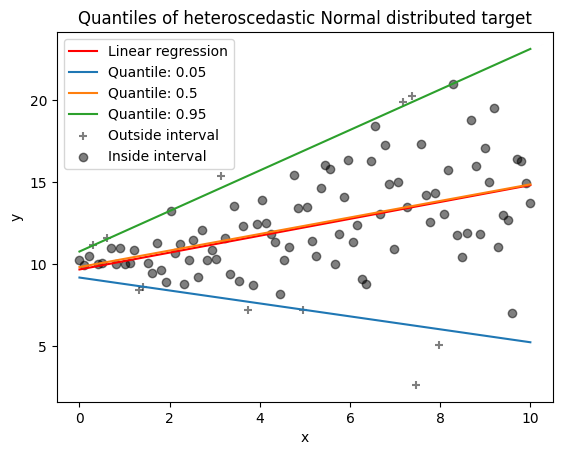

In [180]:
plt.plot(x, y_lin, color="red", linestyle="-", label="Linear regression")

for quantile, y_pred in predictions.items():
    plt.plot(x, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

## Question 3 <a class="anchor" id="Question3"></a>
First, we'll load the dataset:

In [181]:
data3 = pd.read_parquet("data3.parquet")
data3.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Data analysis
We'll start to analyze and understand the data.

In [182]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feat_0   506 non-null    float64
 1   feat_1   506 non-null    float64
 2   feat_2   506 non-null    float64
 3   feat_3   506 non-null    int64  
 4   feat_4   506 non-null    float64
 5   feat_5   506 non-null    float64
 6   feat_6   506 non-null    float64
 7   feat_7   506 non-null    float64
 8   feat_8   506 non-null    int64  
 9   feat_9   506 non-null    float64
 10  feat_10  506 non-null    float64
 11  feat_11  506 non-null    float64
 12  feat_12  506 non-null    float64
 13  label    506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [183]:
desc = data3.describe()
desc

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [184]:
data3.nunique()

feat_0     504
feat_1      26
feat_2      76
feat_3       2
feat_4      81
feat_5     446
feat_6     356
feat_7     412
feat_8       9
feat_9      66
feat_10     46
feat_11    357
feat_12    455
label      229
dtype: int64

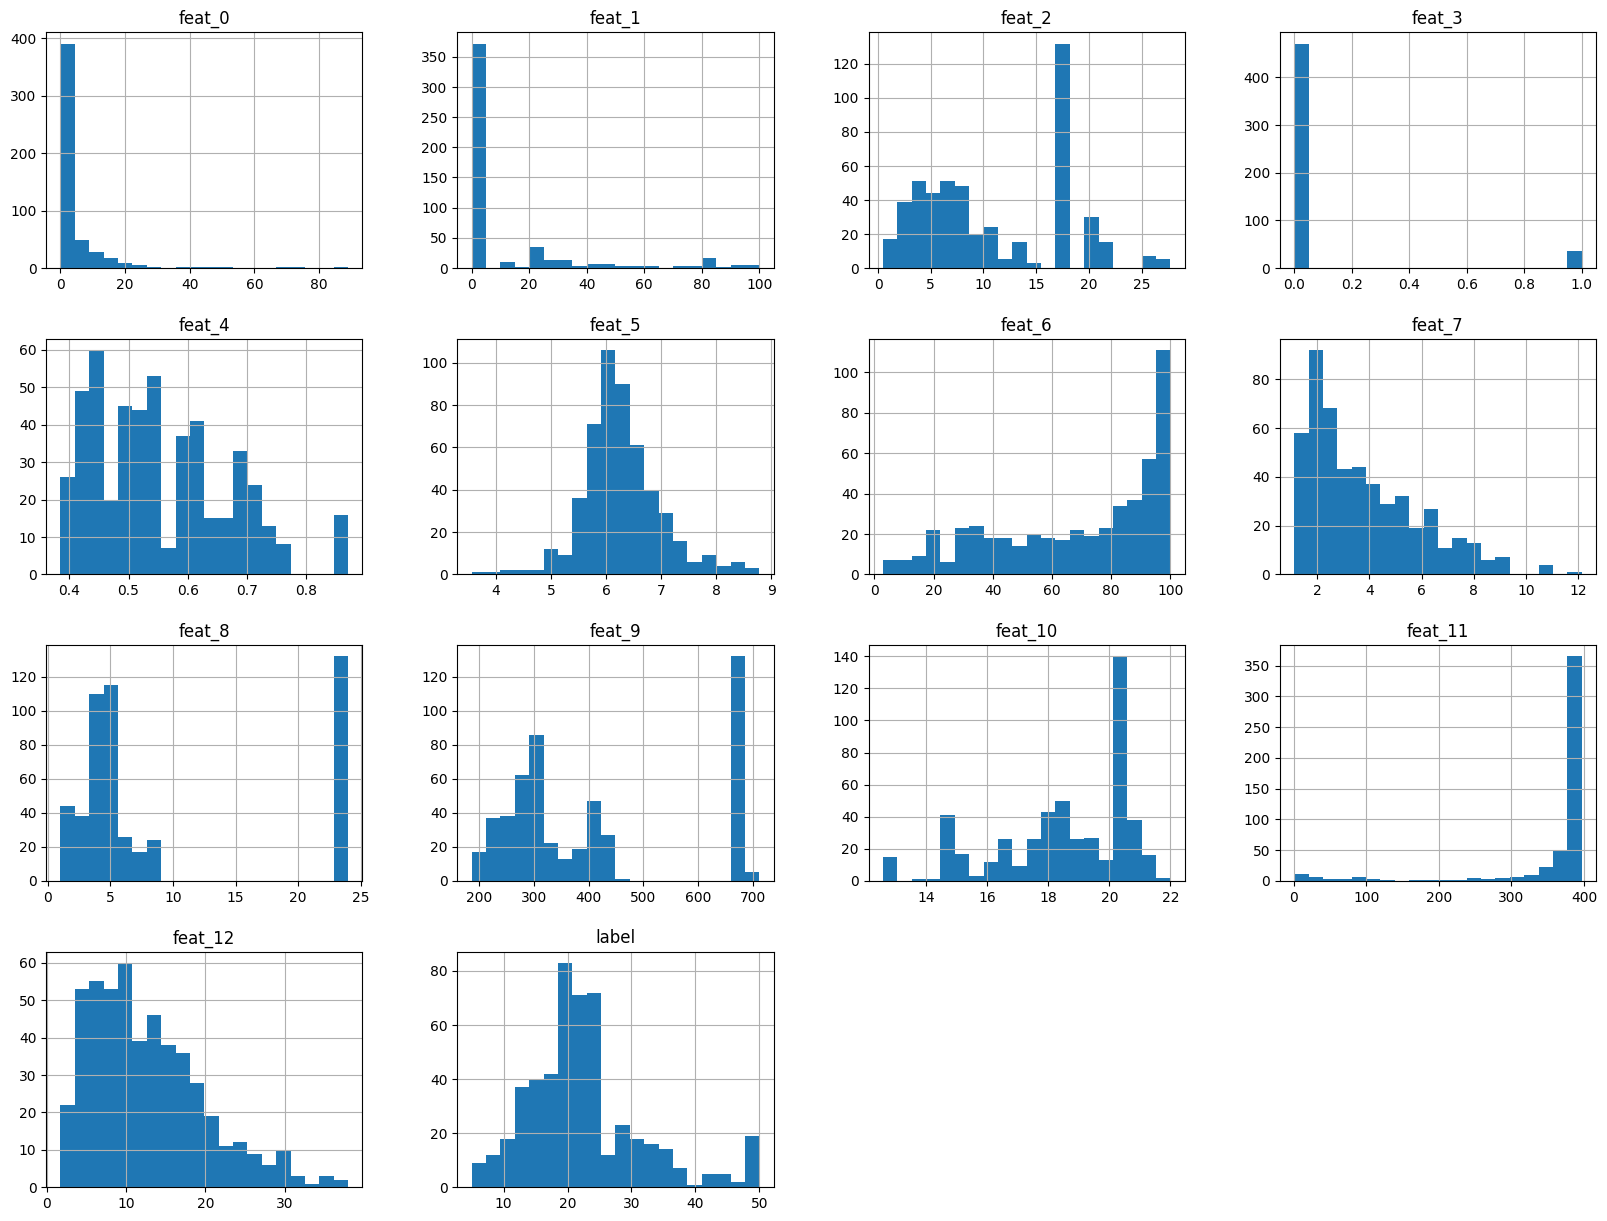

In [185]:
_ = data3.hist(bins=20, figsize=(20,15))

**Insights:**
* Features 3 and 8 seem to be categorical.
* All features except Feature 5 are not distributed normally, and some (like Features 0, 6, 7 and 12) may benefit from a $\log$ transform, as they are skewed.
* Some features have clusters, and it may be beneficial to define categorical variables the capture them.
* The data is biased, meaning the categorical variables are not distributed equally.

### Basic transformations
we'll impelement some of our insights.

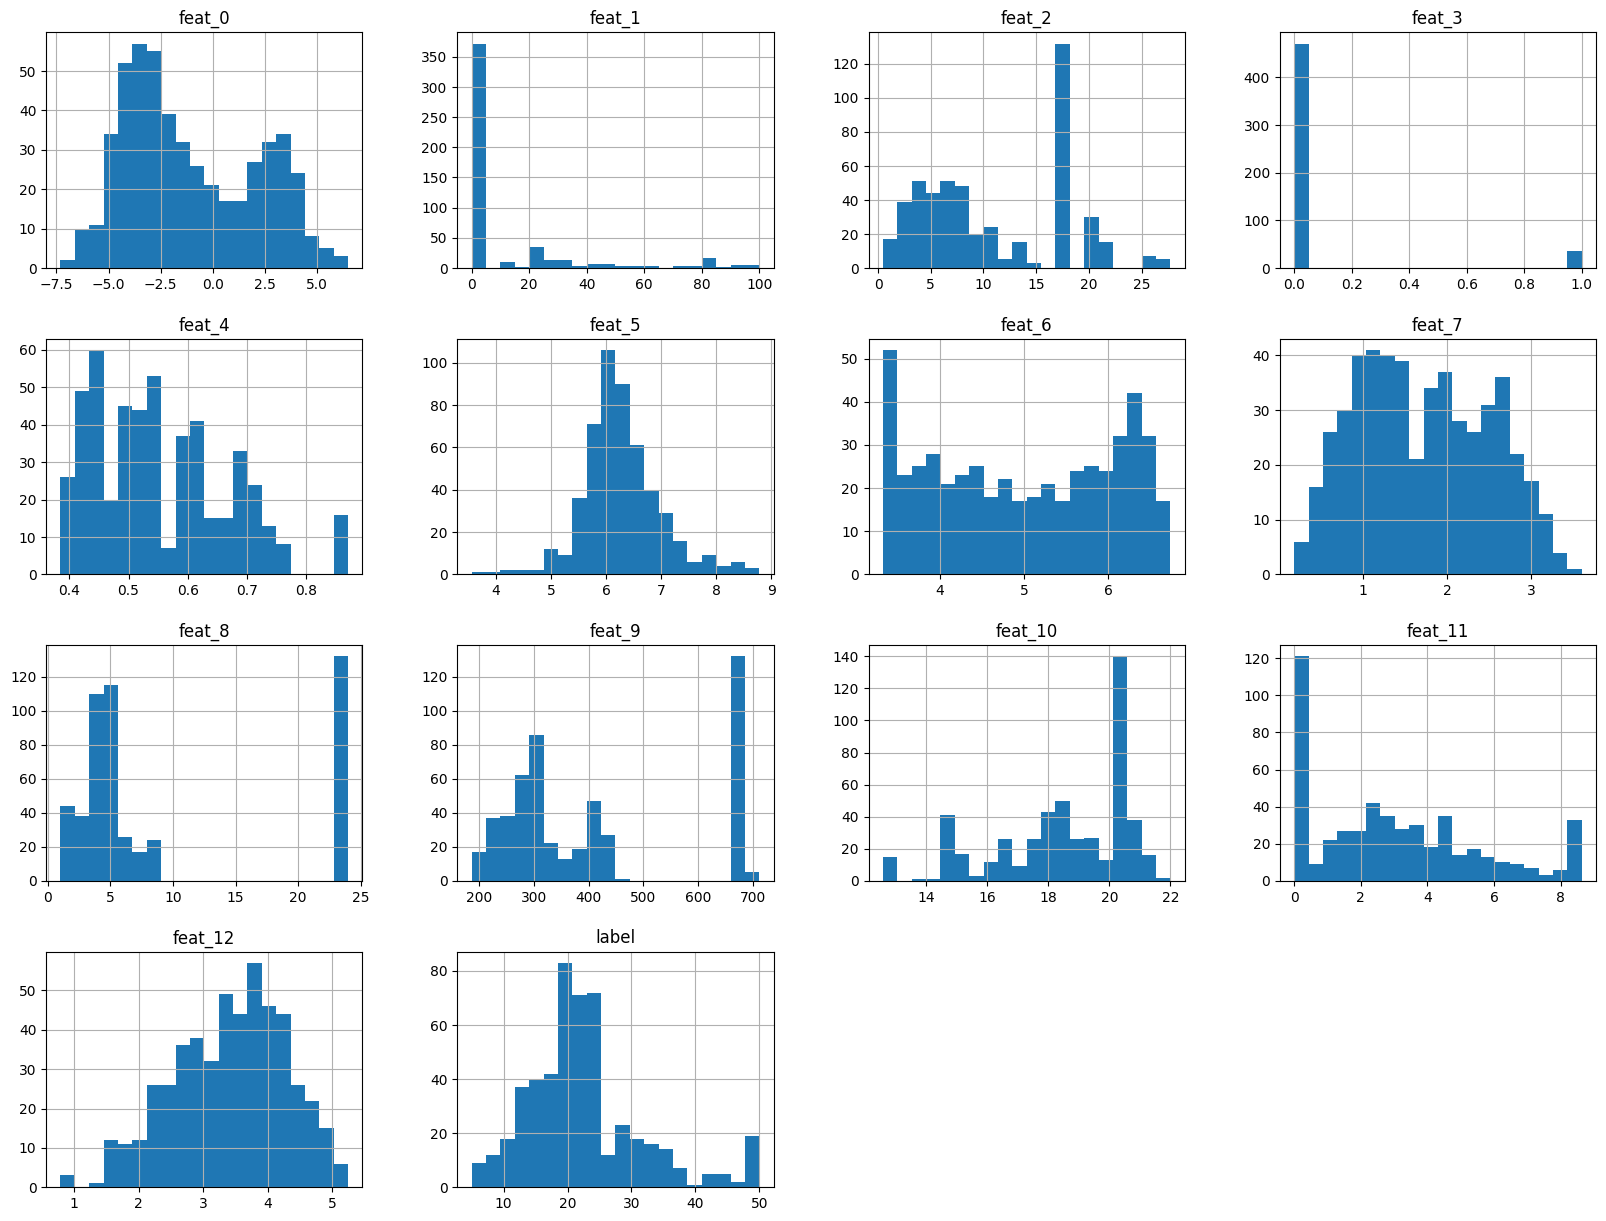

In [186]:
# define skewed features
pos_skew_feats = ["feat_0", "feat_7", "feat_12"]
neg_skew_feats = ["feat_6", "feat_11"]
consts = [10, 1]

#apply log(x) trans. to positively skewed
for feat in pos_skew_feats:
    data3[feat] = np.log2(data3[feat])

#apply log(c-x) trans. to negatively skewed
for i, feat in enumerate(neg_skew_feats):
        data3[feat] = np.log2(desc.loc["max"][feat] + consts[i] - data3[feat])

_ = data3.hist(bins=20, figsize=(20,15))

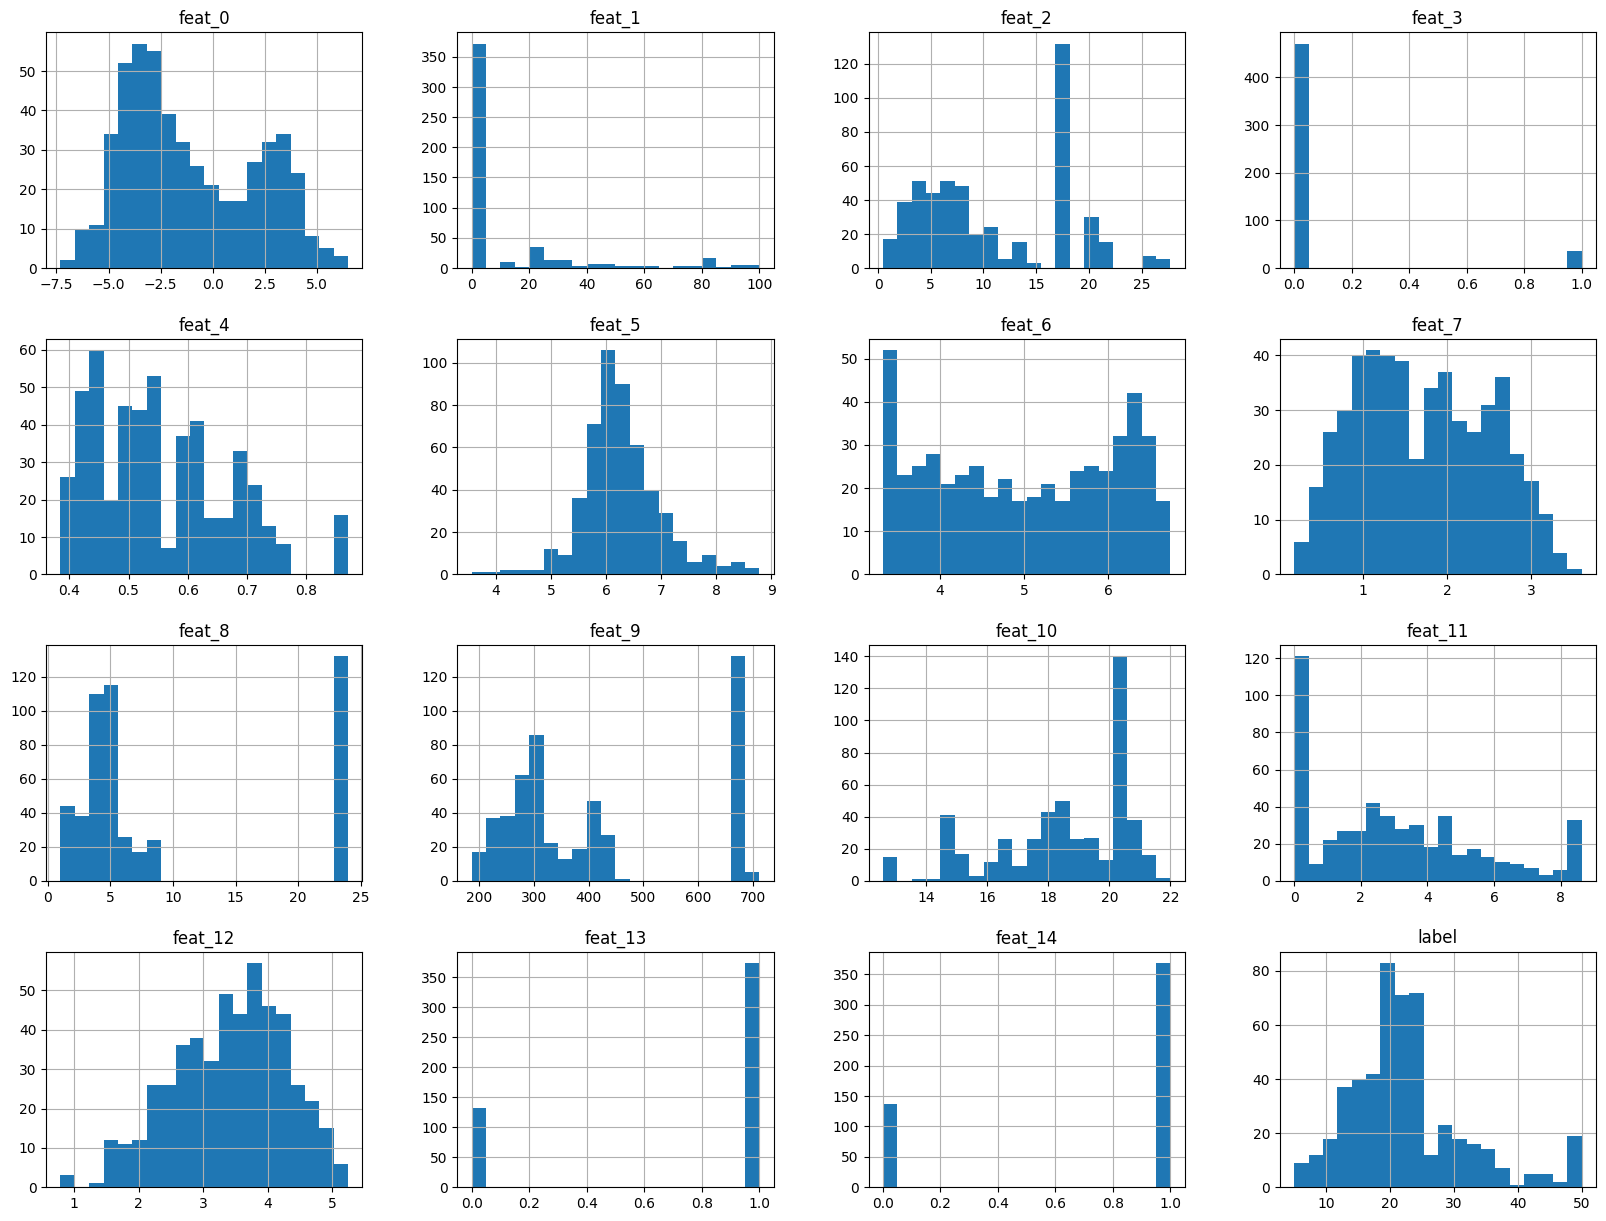

In [187]:
#define categorical variables
data3["feat_13"] = (data3["feat_8"]<10).astype(int)
data3["feat_14"] = (data3["feat_9"]<500).astype(int)
data3.insert(15,"label",data3.pop("label"))

_ = data3.hist(bins=20, figsize=(20,15))

Looks a lot better! now we can look at relations within the data.

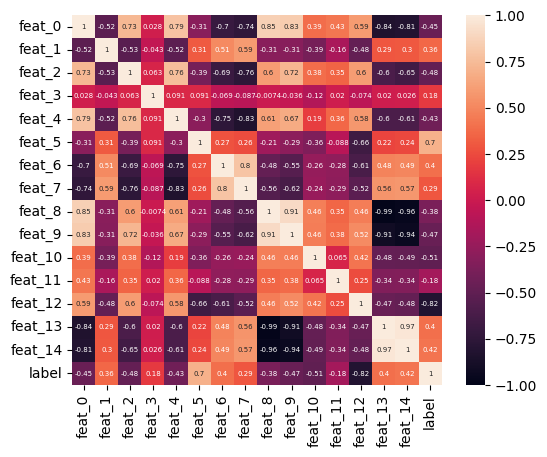

In [188]:
corr_matrix = data3.corr()
sns.heatmap(corr_matrix, square=True, vmax=1.0, vmin=-1.0, annot=True, annot_kws={"size": 5})
plt.show()

In [189]:
sorted_corr = corr_matrix.sort_values(by='label', key=lambda x: abs(x), ascending=False)
corr_col = sorted_corr['label']
corr_col

label      1.000000
feat_12   -0.815442
feat_5     0.695360
feat_10   -0.507787
feat_2    -0.483725
feat_9    -0.468536
feat_0    -0.454302
feat_4    -0.427321
feat_14    0.415181
feat_6     0.396794
feat_13    0.396297
feat_8    -0.381626
feat_1     0.360445
feat_7     0.292316
feat_11   -0.184695
feat_3     0.175260
Name: label, dtype: float64

**Insights:**
* Features 8, 9, 13, and 14 are highly correlated, so it makes sense to keep only one of them.
* Features 3, 11, 7, and 1 don't seem highly correlated to the label, so maybe we should omit them.
* Features 5 and 12 are very important to our predictions.

We'll use these insights to get $X$ and $y$.

### Fit the data

In [190]:
features = data3.drop(["label"],axis=1).columns
# define important features
important = [feat for feat in features if np.abs(corr_col[feat])>0.42]

new = data3[important+["label"]].copy()

In [191]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RepeatedKFold

# scale data
scaler = StandardScaler()
scaled = scaler.fit_transform(new)
X = scaled[:,:-1]
y = scaled[:,-1]

# define parameters
parameters = {'alpha':np.arange(0, 1.01 ,0.01)}
n_splits = 10
n_repeats = 3
# define the model/ estimator
model = Ridge()
# define the repeated k-fold
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_absolute_error',cv=rkf)

#fit the grid search
Ridge_reg.fit(X,y)

# best params
pd.DataFrame(Ridge_reg.cv_results_)

# best model
alpha = Ridge_reg.best_params_['alpha']
mae = -Ridge_reg.best_score_
print(f"Best parameter:\t {alpha}\nMAE:\t\t {mae}")

Best parameter:	 1.0
MAE:		 0.3747685570178831
